In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from geomloss import SamplesLoss
from sklearn.preprocessing import MaxAbsScaler

def rossler(xyz, a=0.2, b=0.2, c=5.7):
    x, y, z = xyz
    x_dot = -y - z
    y_dot = x + a * y
    z_dot = b + z * (x - c)
    return np.array([x_dot, y_dot, z_dot], dtype=np.float64)

def delay_embed_scalar(X, tau, dim):
    new = np.zeros((len(X) - tau * dim, dim), dtype=np.float64)
    for i in range(dim):
        new[:, i] = X[dim * tau - (i + 1) * tau: -(1 + i) * tau]
    return new

@torch.no_grad()
def rollout_mse(net, y_scaled, transformer, dt, H=200, n_eval=50, seed=0):
    rng = np.random.default_rng(seed)
    N = len(y_scaled)
    idxs = rng.integers(0, N - H - 1, size=n_eval)

    mse_list = []
    for idx in idxs:
        x = torch.tensor(y_scaled[idx], dtype=torch.float32)
        xs = [x.detach().cpu().numpy()]
        for _ in range(H):
            x = x + dt * net(x)
            xs.append(x.detach().cpu().numpy())
        xs = np.array(xs)

        xs_un = transformer.inverse_transform(xs)
        yt_un = transformer.inverse_transform(y_scaled[idx: idx + H + 1])
        mse_list.append(np.mean((xs_un - yt_un) ** 2))

    return float(np.mean(mse_list)), float(np.std(mse_list))

def train_DIM_only(
    obs_idx,
    dt=0.01,
    num_steps=int(2e5),
    tau=100,
    dim_delay=3,
    num_samples=5000,
    Nsteps=10000,
    lr=1e-3,
    seed=0,
    split_ratio=0.7,
    print_every=100,
):
    np.random.seed(seed)
    torch.manual_seed(seed)

    y = np.zeros((num_steps + 1, 3), dtype=np.float64)
    y[0] = np.array([1.0, 1.0, 0.0], dtype=np.float64)
    for i in range(num_steps):
        y[i + 1] = y[i] + rossler(y[i]) * dt

    transformer = MaxAbsScaler().fit(y)
    y_scaled_full = transformer.transform(y)

    obs_series = y_scaled_full[:, obs_idx]
    y_delay = delay_embed_scalar(obs_series, tau=tau, dim=dim_delay)

    y_scaled = y_scaled_full[:-(dim_delay - 1) * tau]
    y_scaled = y_scaled[:-tau]

    split = int(split_ratio * len(y_scaled))
    y_tr, y_va = y_scaled[:split], y_scaled[split:]
    ydelay_tr, ydelay_va = y_delay[:split], y_delay[split:]

    batch_ixs_tr = np.arange(len(y_tr))
    batch_ixs_va = np.arange(len(y_va))

    net = nn.Sequential(
        nn.Linear(3, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 3),
    )

    loss = SamplesLoss(loss="energy")
    optimizer = optim.Adam(net.parameters(), lr=lr)

    train_log = []

    net.train()
    for step in range(Nsteps):
        bs_tr = min(num_samples, len(batch_ixs_tr))
        ixs = np.random.choice(batch_ixs_tr, size=bs_tr, replace=False)

        y_batch = torch.tensor(y_tr[ixs], dtype=torch.float32)
        y_delay_batch = torch.tensor(ydelay_tr[ixs], dtype=torch.float32)

        optimizer.zero_grad()

        sols = []
        yy = y_batch
        for _ in range(tau * dim_delay):
            sols.append(yy)
            yy = yy + dt * net(yy)

        sol = torch.stack(sols, dim=0)
        DIM = torch.flip(sol[::tau, :, obs_idx].T, dims=[1])

        L = loss(DIM, y_delay_batch)
        L.backward()
        optimizer.step()

        if step % print_every == 0:
            net.eval()

            bs_va = min(num_samples, len(batch_ixs_va))
            jxs = np.random.choice(batch_ixs_va, size=bs_va, replace=False)
            yv_batch = torch.tensor(y_va[jxs], dtype=torch.float32)
            yv_delay_batch = torch.tensor(ydelay_va[jxs], dtype=torch.float32)

            sols_v = []
            yyv = yv_batch
            for _ in range(tau * dim_delay):
                sols_v.append(yyv)
                yyv = yyv + dt * net(yyv)

            sol_v = torch.stack(sols_v, dim=0)
            DIM_v = torch.flip(sol_v[::tau, :, obs_idx].T, dims=[1])

            Lv = float(loss(DIM_v, yv_delay_batch).detach().cpu().item())
            Lt = float(L.detach().cpu().item())

            train_log.append({"step": int(step), "train_dim_loss": Lt, "val_dim_loss": Lv})
            print(f"step={step:5d} | train DIM loss={Lt:.6g} | val DIM loss={Lv:.6g}")

            net.train()

    net.eval()
    return net, transformer, y_va, train_log

def save_model(net, transformer, fname, cfg, train_log=None):
    ckpt = {
        "state_dict": net.state_dict(),
        "transformer": transformer,
        "config": cfg,
    }
    if train_log is not None:
        ckpt["train_log"] = train_log
    torch.save(ckpt, fname)

dt = 0.01
tau = 30
dim_delay = 5
num_steps = 5000
num_samples = 2500
Nsteps = 3000
lr = 1e-3
split_ratio = 0.7
print_every = 100

H_short = 200
H_mid = 1000
n_eval = 50

results = []

for name, obs_idx in [("x", 0), ("z", 2)]:
    net, transformer, y_val, train_log = train_DIM_only(
        obs_idx=obs_idx,
        dt=dt,
        num_steps=num_steps,
        tau=tau,
        dim_delay=dim_delay,
        num_samples=num_samples,
        Nsteps=Nsteps,
        lr=lr,
        seed=0,
        split_ratio=split_ratio,
        print_every=print_every,
    )

    cfg = {
        "obs": name,
        "obs_idx": obs_idx,
        "dt": dt,
        "num_steps": num_steps,
        "tau": tau,
        "dim_delay": dim_delay,
        "num_samples": num_samples,
        "Nsteps": Nsteps,
        "lr": lr,
        "split_ratio": split_ratio,
        "print_every": print_every,
    }

    save_model(net, transformer, f"rossler_DIM_only_{name}.pt", cfg, train_log=train_log)

    log_df = pd.DataFrame(train_log)
    log_df.to_csv(f"rossler_DIM_only_{name}_trainlog.csv", index=False)

    mse_s, std_s = rollout_mse(net, y_val, transformer, dt, H=H_short, n_eval=n_eval, seed=1)
    mse_m, std_m = rollout_mse(net, y_val, transformer, dt, H=H_mid, n_eval=n_eval, seed=2)

    results.append((name, H_short, mse_s, std_s))
    results.append((name, H_mid, mse_m, std_m))

print("\n=== Rössler DIM-only training: rollout MSE on validation (original scale) ===")
for name, H, mse, std in results:
    print(f"observable={name:2s} | horizon={H:4d} | MSE={mse:.6g} ± {std:.3g}")

print("\nSaved models: rossler_DIM_only_x.pt and rossler_DIM_only_z.pt")
print("Saved logs  : rossler_DIM_only_x_trainlog.csv and rossler_DIM_only_z_trainlog.csv")

step=    0 | train DIM loss=0.0281227 | val DIM loss=0.0252335
step=  100 | train DIM loss=0.00150013 | val DIM loss=0.00490844
step=  200 | train DIM loss=0.000710011 | val DIM loss=0.00541115
step=  300 | train DIM loss=0.00103843 | val DIM loss=0.00661695
step=  400 | train DIM loss=0.000936389 | val DIM loss=0.00575829
step=  500 | train DIM loss=0.00126672 | val DIM loss=0.0064671
step=  600 | train DIM loss=0.000522017 | val DIM loss=0.00464272
step=  700 | train DIM loss=0.000707507 | val DIM loss=0.00596523
step=  800 | train DIM loss=0.000524402 | val DIM loss=0.00374019
step=  900 | train DIM loss=0.000516176 | val DIM loss=0.00614417
step= 1000 | train DIM loss=0.000715494 | val DIM loss=0.00301898
step= 1100 | train DIM loss=0.00050652 | val DIM loss=0.00701308
step= 1200 | train DIM loss=0.00102496 | val DIM loss=0.00597119
step= 1300 | train DIM loss=0.000538588 | val DIM loss=0.00620353
step= 1400 | train DIM loss=0.000436306 | val DIM loss=0.00592363
step= 1500 | train 

## More Horizons


=== Fine horizon sweep on VALIDATION (original scale) ===
x model:
H= 100 | MSE=18.6579 + ± 19.2
H= 200 | MSE=47.0065 + ± 29.3
H= 300 | MSE=61.9096 + ± 45.2
H= 400 | MSE=66.7038 + ± 62.3
H= 500 | MSE=108.155 + ± 86
H= 600 | MSE=91.309 + ± 86.7
H= 700 | MSE=104.788 + ± 95
H= 800 | MSE=114.44 + ± 107

z model:
H= 100 | MSE=12.9307 + ± 17.8
H= 200 | MSE=60.7905 + ± 54.1
H= 300 | MSE=88.4519 + ± 84.8
H= 400 | MSE=238.007 + ± 201
H= 500 | MSE=480.729 + ± 296
H= 600 | MSE=688.102 + ± 440
H= 700 | MSE=768.67 + ± 529
H= 800 | MSE=1192.34 + ± 684


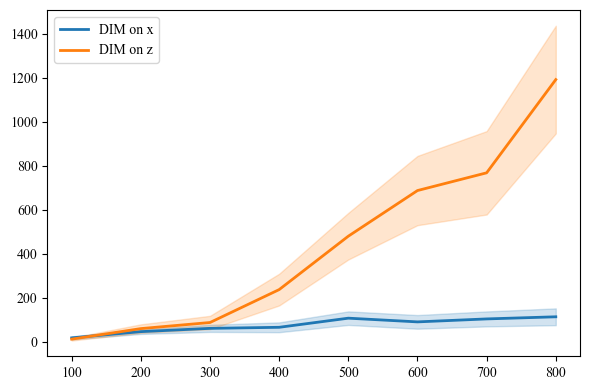

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from geomloss import SamplesLoss
from sklearn.preprocessing import MaxAbsScaler
plt.rcParams["font.family"] = "Times New Roman"

def rossler(xyz, a=0.2, b=0.2, c=5.7):
    x, y, z = xyz
    x_dot = -y - z
    y_dot = x + a * y
    z_dot = b + z * (x - c)
    return np.array([x_dot, y_dot, z_dot], dtype=np.float64)

def simulate_rossler(dt, num_steps, seed=0):
    np.random.seed(seed)
    y = np.zeros((num_steps + 1, 3), dtype=np.float64)
    y[0] = np.array([1.0, 1.0, 0.0], dtype=np.float64)
    for i in range(num_steps):
        y[i + 1] = y[i] + rossler(y[i]) * dt
    return y

@torch.no_grad()
def rollout_mse(net, y_scaled, transformer, dt, H=200, n_eval=30, seed=0):
    rng = np.random.default_rng(seed)
    N = len(y_scaled)
    idxs = rng.integers(0, N - H - 1, size=n_eval)

    mse_list = []
    for idx in idxs:
        x = torch.tensor(y_scaled[idx], dtype=torch.float32)
        xs = [x.detach().cpu().numpy()]
        for _ in range(H):
            x = x + dt * net(x)
            xs.append(x.detach().cpu().numpy())
        xs = np.array(xs)

        xs_un = transformer.inverse_transform(xs)
        yt_un = transformer.inverse_transform(y_scaled[idx: idx + H + 1])
        mse_list.append(np.mean((xs_un - yt_un) ** 2))

    return float(np.mean(mse_list)), float(np.std(mse_list))

def build_net():
    return nn.Sequential(
        nn.Linear(3, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 3),
    )

def eval_saved_model(model_path, horizon_list, n_eval=30):
    ckpt = torch.load(model_path, map_location="cpu", weights_only=False)
    cfg = ckpt["config"]

    dt = cfg["dt"]
    num_steps = cfg["num_steps"]
    tau = cfg["tau"]
    dim_delay = cfg["dim_delay"]
    split_ratio = cfg["split_ratio"]

    y = simulate_rossler(dt=dt, num_steps=num_steps, seed=0)
    transformer = MaxAbsScaler().fit(y)
    y_scaled_full = transformer.transform(y)

    y_scaled = y_scaled_full[:-(dim_delay - 1) * tau]
    y_scaled = y_scaled[:-tau]

    split = int(split_ratio * len(y_scaled))
    y_val = y_scaled[split:]

    net = build_net()
    net.load_state_dict(ckpt["state_dict"])
    net.eval()

    out = []
    for H in horizon_list:
        mse, std = rollout_mse(net, y_val, transformer, dt, H=H, n_eval=n_eval, seed=1000 + H)
        out.append((H, mse, std))
    return out

H_list = [100, 200, 300, 400, 500, 600, 700, 800]

res_x = eval_saved_model("rossler_DIM_only_x.pt", H_list, n_eval=30)
res_z = eval_saved_model("rossler_DIM_only_z.pt", H_list, n_eval=30)

print("\n=== Fine horizon sweep on VALIDATION (original scale) ===")
print("x model:")
for H, mse, std in res_x:
    print(f"H={H:4d} | MSE={mse:.6g} + ± {std:.3g}")

print("\nz model:")
for H, mse, std in res_z:
    print(f"H={H:4d} | MSE={mse:.6g} + ± {std:.3g}")

def plot_mse_with_ci(res_x, res_z, n_eval):
    H = np.array([h for h, _, _ in res_x], dtype=float)

    x_mse = np.array([m for _, m, _ in res_x], dtype=float)
    x_std = np.array([s for _, _, s in res_x], dtype=float)

    z_mse = np.array([m for _, m, _ in res_z], dtype=float)
    z_std = np.array([s for _, _, s in res_z], dtype=float)

    z_val = 1.96
    x_half = z_val * x_std / np.sqrt(n_eval)
    z_half = z_val * z_std / np.sqrt(n_eval)

    x_low, x_high = x_mse - x_half, x_mse + x_half
    z_low, z_high = z_mse - z_half, z_mse + z_half

    x_low = np.maximum(x_low, 0.0)
    z_low = np.maximum(z_low, 0.0)

    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(H, x_mse, color="C0", lw=2.0, label="DIM on x")
    ax.fill_between(H, x_low, x_high, color="C0", alpha=0.2)

    ax.plot(H, z_mse, color="C1", lw=2.0, label="DIM on z")
    ax.fill_between(H, z_low, z_high, color="C1", alpha=0.2)

    ax.legend()
    ax.grid(False)

    fig.tight_layout()
    fig.savefig("rossler_DIM_only_rollout_mse.png", dpi=600, bbox_inches="tight", pad_inches=0.1)
    plt.show()

plot_mse_with_ci(res_x, res_z, n_eval=30)

(np.float64(-10.37186071300502),
 np.float64(12.890939345293296),
 np.float64(-10.37186071300502),
 np.float64(12.890939345293296),
 np.float64(-9.314460710355096),
 np.float64(11.833539342643371))

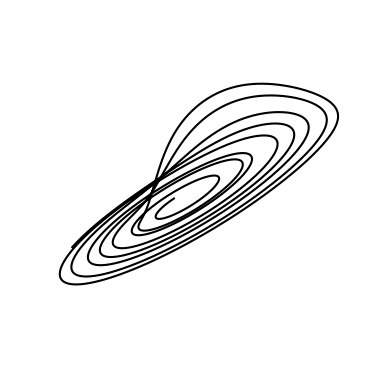

In [20]:
def delay_embed_scalar(X, tau, dim):
    new = np.zeros((len(X) - tau * dim, dim), dtype=np.float64)
    for i in range(dim):
        new[:, i] = X[dim * tau - (i + 1) * tau: -(1 + i) * tau]
    return new
num_steps = 5000
dt = 0.01
y = np.zeros((num_steps + 1, 3), dtype=np.float64)
y[0] = np.array([1.0, 1.0, 0.0], dtype=np.float64)
for i in range(num_steps):
    y[i + 1] = y[i] + rossler(y[i]) * dt
Ztr = delay_embed_scalar(y[:, 0], tau=30, dim=5)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=Ztr[:,0], ys=Ztr[:,1], zs=Ztr[:,2], color='k')
plt.axis('off')

(np.float64(-250.0),
 np.float64(5250.0),
 np.float64(-10.176071457194727),
 np.float64(12.43851509390617))

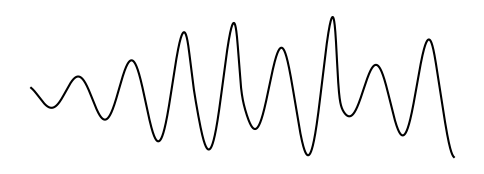

In [13]:
plt.figure(figsize=(6,2))
plt.plot(y[:,0],'k')
plt.xticks([])
plt.yticks([])
plt.axis('off')

(np.float64(-250.0),
 np.float64(5250.0),
 np.float64(-1.1290880798022673),
 np.float64(23.710849675847612))

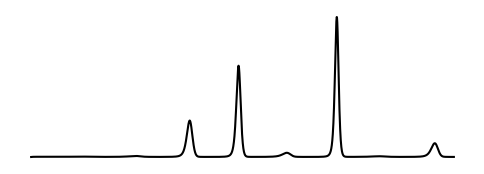

In [14]:
plt.figure(figsize=(6,2))
plt.plot(y[:,2],'k')
plt.xticks([])
plt.yticks([])
plt.axis('off')

(np.float64(-1.6318625930195982),
 np.float64(24.227347705981796),
 np.float64(-1.6318625930195982),
 np.float64(24.227347705981796),
 np.float64(-0.4564439430649892),
 np.float64(23.05192905602719))

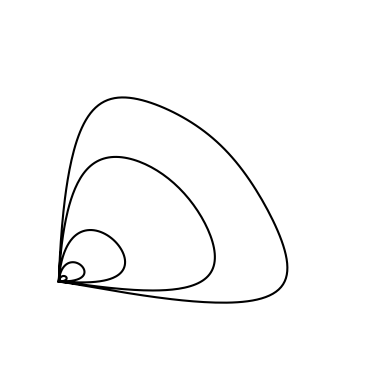

In [21]:
Ztr1 = delay_embed_scalar(y[:, 2], tau=30, dim=5)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=Ztr1[:,0], ys=Ztr1[:,1], zs=Ztr1[:,2], color='k')
plt.axis('off')

In [ ]:
import numpy as np

def rossler(x, a=0.2, b=0.2, c=5.7):
    x_, y_, z_ = x
    return np.array([
        -y_ - z_,
         x_ + a * y_,
         b + z_ * (x_ - c)
    ], dtype=float)

def rk4_step(f, x, dt):
    k1 = f(x)
    k2 = f(x + 0.5*dt*k1)
    k3 = f(x + 0.5*dt*k2)
    k4 = f(x + dt*k3)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def estimate_lyapunov_max(
    dt=0.01,
    T_total=3000.0,
    T_transient=500.0,
    renorm_every=10,
    delta0=1e-8,
    x0=np.array([1.0, 1.0, 0.0])
):
    n_total = int(T_total / dt)
    n_trans = int(T_transient / dt)

    x = x0.astype(float)

    v = np.random.randn(3)
    v = delta0 * v / np.linalg.norm(v)
    x_pert = x + v

    log_sum = 0.0
    count = 0

    for n in range(n_total):
        for _ in range(renorm_every):
            x = rk4_step(rossler, x, dt)
            x_pert = rk4_step(rossler, x_pert, dt)

        v = x_pert - x
        d = np.linalg.norm(v)

        if n * renorm_every >= n_trans:
            log_sum += np.log(d / delta0)
            count += 1

        v = delta0 * v / d
        x_pert = x + v

    lam = log_sum / (count * renorm_every * dt)
    return lam

lam = estimate_lyapunov_max(dt=0.01)
print("lambda_max ≈", lam)
print("Lyapunov time T_L ≈", 1/lam)
print("Lyapunov steps H_L ≈", 1/(lam*0.01))

lambda_max ≈ 0.0714044690926295
Lyapunov time T_L ≈ 14.004725652434294
Lyapunov steps H_L ≈ 1400.4725652434295


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from numba import jit
import warnings
@jit(nopython=True, fastmath=True)
def compute_errors_numba(neighbor_clouds, max_iter=50, eps=1e-5):
    n_samples, k, dim = neighbor_clouds.shape
    errors = np.empty(n_samples, dtype=np.float64)
    
    for i in range(n_samples):
        cloud = neighbor_clouds[i]
        
        y = np.zeros(dim)
        for d in range(dim):
            sum_val = 0.0
            for j in range(k):
                sum_val += cloud[j, d]
            y[d] = sum_val / k
            
        for _ in range(max_iter):
            sum_weights = 0.0
            y_next = np.zeros(dim)
            distances = np.empty(k)
            all_non_zero = True
            
            for j in range(k):
                dist_sq = 0.0
                for d in range(dim):
                    diff = cloud[j, d] - y[d]
                    dist_sq += diff * diff
                dist = np.sqrt(dist_sq)
                distances[j] = dist
                
                if dist < 1e-10: 
                    all_non_zero = False
                    for d in range(dim): y[d] = cloud[j, d]
                    break
                
                w = 1.0 / dist
                sum_weights += w
                for d in range(dim):
                    y_next[d] += cloud[j, d] * w
            
            if not all_non_zero: break 
            
            diff_norm_sq = 0.0
            for d in range(dim):
                y_next[d] /= sum_weights
                diff = y[d] - y_next[d]
                diff_norm_sq += diff * diff
                y[d] = y_next[d]
                
            if np.sqrt(diff_norm_sq) < eps:
                break
        
        total_dist = 0.0
        for j in range(k):
            dist_sq = 0.0
            for d in range(dim):
                diff = cloud[j, d] - y[d]
                dist_sq += diff * diff
            total_dist += np.sqrt(dist_sq)
            
        errors[i] = total_dist / k
        
    return errors

def check_embedding_condition(data, threshold=1e10):
    data_centered = data - np.mean(data, axis=0)
    s = np.linalg.svdvals(data_centered)
    if s[-1] < 1e-12:
        return np.inf
    return s[0] / s[-1]

def power_law_model(k, intercept, coef, gamma):
    return intercept + coef * (k ** gamma)

# Estimate intrinsic stochasticity at fixed k
import numpy as np
import warnings
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors

def estimate_intrinsic_stochasticity(
    embedding_data,
    pushforward,
    k=50,
    n_samples=5000,
    cond_threshold=1000,
    random_state=0,
    return_pointwise=False,
    theiler_w=0,          
    buffer_mult=6,        
    pre_scaled=False,     
    strict_theiler=True,  
):
    if k <= 1:
        raise ValueError("k must be >= 2.")
    if pushforward <= 0:
        raise ValueError("pushforward must be >= 1.")
    if theiler_w < 0:
        raise ValueError("theiler_w must be >= 0.")
    if buffer_mult < 1:
        raise ValueError("buffer_mult must be >= 1.")

    if pre_scaled:
        data_norm = np.asarray(embedding_data)
    else:
        scaler = RobustScaler()
        data_norm = scaler.fit_transform(np.asarray(embedding_data))

    cond_num = check_embedding_condition(data_norm)
    if (cond_num > cond_threshold) or np.isinf(cond_num):
        warnings.warn(
            f"Rank Deficient"
        )
        return None

    T = data_norm.shape[0]
    max_start = T - pushforward

    X_curr = data_norm[:max_start]
    Y_fut  = data_norm[pushforward:]

    rng = np.random.default_rng(random_state)
    n_q = int(min(n_samples, max_start))
    query_idx = rng.choice(max_start, size=n_q, replace=False)

    k_query = int(min(max_start, max(k * buffer_mult, k + 2 * theiler_w + 5)))
    nbrs = NearestNeighbors(n_neighbors=k_query, algorithm="auto", n_jobs=-1).fit(X_curr)

    dist_raw, idx_raw = nbrs.kneighbors(X_curr[query_idx]) 

    nn_idx = np.empty((n_q, k), dtype=np.int64)
    rk = np.empty(n_q, dtype=np.float64)  

    not_enough = 0

    for r in range(n_q):
        q = int(query_idx[r])
        cand = idx_raw[r]
        cand_d = dist_raw[r]

        picked = 0
        last_d = 0.0

        for j in range(k_query):
            t = int(cand[j])
            if t == q:
                continue
            if theiler_w > 0 and (abs(t - q) <= theiler_w):
                continue
            nn_idx[r, picked] = t
            last_d = float(cand_d[j])  
            picked += 1
            if picked == k:
                break

        if picked < k:
            not_enough += 1
            if strict_theiler:
                raise RuntimeError(
                    f"Not enough valid neighbors after exclusion"
                )
            else:
                picked2 = 0
                last_d = 0.0
                for j in range(k_query):
                    t = int(cand[j])
                    if t == q:
                        continue
                    nn_idx[r, picked2] = t
                    last_d = float(cand_d[j])
                    picked2 += 1
                    if picked2 == k:
                        break

        rk[r] = last_d

    neighbor_clouds = Y_fut[nn_idx]  

    local_errors = compute_errors_numba(neighbor_clouds)
    E_star_k = float(np.mean(local_errors))

    out = {
        "E_star_k": E_star_k,
        "k": int(k),
        "pushforward": int(pushforward),
        "theiler_w": int(theiler_w),
        "n_queries": int(n_q),
        "condition_number": float(cond_num),
        "not_enough_queries": int(not_enough),
        "strict_theiler": bool(strict_theiler),
        "median_rk": float(np.median(rk)),
        "q90_rk": float(np.quantile(rk, 0.90)),
        "mean_rk": float(np.mean(rk)),
    }
    if return_pointwise:
        out["pointwise_errors"] = local_errors
        out["query_idx"] = query_idx
        out["nn_idx"] = nn_idx
        out["rk"] = rk
    return out

In [22]:
print(estimate_intrinsic_stochasticity(Ztr, pushforward=20, k=50, n_samples=2000, random_state=0)['E_star_k'])
print(estimate_intrinsic_stochasticity(Ztr1, pushforward=20, k=50, n_samples=2000, random_state=0)['E_star_k'])

0.1351591144631509
5.792407896635191
